# Master's research code draft.
## PAH clustering
### Will be exploring agglomerative/heirarchical clustering on both Spitzer and JWST data; will also compare to results of similar works (ie Boersma 2014).

### Sofia Pasquini

#### Just a draft at the moment, main code developped in github.com/sofiapasquini/PAH-revolution

In [1]:
#import some relevant packages
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score #(?)
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import interpolate

## Pre-processing
### Load in the data and construct the spectra

In [2]:
#load in the data 

folder="/Volumes/LaCie/MASTERS/NGC2023_IRS_Boersma_2016/"
file_name= "NGC2023_SPECTRAL_MAP_SOUTH.fits" #just for now
hdulist = fits.open(folder+file_name)

### Wavelength array

In [3]:
#read the wavelength data and inspect type/shape
wave=hdulist[1].data['wavelength']
print(type(wave))
print(wave.shape)

<class 'numpy.ndarray'>
(1, 194, 1)


In [4]:
#reshape the wavelength array from 3 to 1 dimension
wave=np.reshape(wave, -1)
print(type(wave))
print(wave.shape)

<class 'numpy.ndarray'>
(194,)


In [5]:
#now read in the data and check the type/shape
spectra=hdulist[0].data
print(type(spectra))
print(spectra.shape)

<class 'numpy.ndarray'>
(194, 17, 27)


In [6]:
#we want to rearrange so the dimensions are (x, y, lambda)
spectra = np.moveaxis(np.swapaxes(spectra, 1, 2), 0, 2) 
print(spectra.shape)
print(spectra.shape[0], spectra.shape[1])

(27, 17, 194)
27 17


In [7]:
#make sure to close the file after we are done
hdulist.close()

### Continua

In [11]:
#now we wish to read in the continuum data
file_name='NGC2023_CONTINUUM_MAP_SOUTH.fits'
hdulist=fits.open(folder+file_name)

In [12]:
#first the wavelengths
wave_cont=hdulist[1].data['wavelength']
print(wave_cont.shape)
print(type(wave_cont))

(89046,)
<class 'numpy.ndarray'>


In [13]:
#we now have the wavelength array repeated for each pixel
#we want to reshape such that the wavelength array has the same format as the spectral cube
wave_cont=np.reshape(wave_cont, [27, 17, 194], order='F') #"F" means the first index varies the fastest and the last one the slowest.

(27, 17, 194)


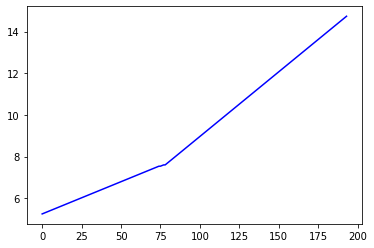

<Figure size 432x288 with 0 Axes>

In [14]:
# make integer array and test result!
test = np.arange(194)
print(wave_cont.shape)
plt.plot(test, wave_cont[10,10,:], color='b')
plt.show()
plt.clf()

In [15]:
#now get the continuum data
cont=hdulist[0].data
print(cont.shape)
print(type(cont))


(194, 17, 27)
<class 'numpy.ndarray'>


In [16]:
#reshape as we did before
cont = np.moveaxis(np.swapaxes(cont, 1, 2), 0, 2)
print(cont.shape)
print(type(cont))

(27, 17, 194)
<class 'numpy.ndarray'>


In [17]:
#close that file
hdulist.close()

### Extinction maps

In [18]:
file_name= 'NGC2023_EXTINCTION_MAPS_SOUTH.fits'
hdulist=fits.open(folder+file_name)

In [19]:
#read in the wavelength array
wave_ext= hdulist[2].data['wavelength']
print(wave_ext.shape)
print(type(wave_ext))

(194,)
<class 'numpy.ndarray'>


In [20]:
#read in the extinction data
ext= hdulist[1].data
print(ext.shape)

(194, 17, 27)


In [21]:
#reshape as we did before
ext = np.moveaxis(np.swapaxes(ext, 1, 2), 0, 2)
print(ext.shape)

(27, 17, 194)


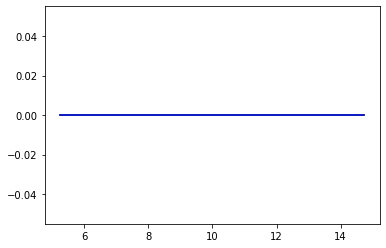

In [22]:
# check if all wavelength arrays are the same ---> Yes!
plt.plot(wave, wave-wave_ext, color='r')
plt.plot(wave, wave-wave_cont[15, 15, :], color='g')
plt.plot(wave, wave_cont[4,4,:]-wave_cont[15, 15, :], color='b')
plt.show()


In [23]:
# #lets plot the spectrum with the corresponding continuum in a pdf

# from matplotlib.backends.backend_pdf import PdfPages

# with PdfPages('plot_spectra_cont_C.pdf') as pdf:
# 	for i in np.arange(len(spectra[:, 0, 0])):
# 		for j in np.arange(len(spectra[0, :, 0])):
# 			plt.figure(figsize=(3, 3))
# 			plt.plot(wave, spectra[i, j, :], color='b')
# 			plt.plot(wave, cont[i, j, :], color='r')
# 			plt.plot(wave, ext[i,j,:]*100, color='g')
# 			plt.title('('+str(i)+','+str(j)+')')
# 			pdf.savefig()  # saves the current figure into a pdf page
# 			plt.close()

### Extinction Correction + Continuum Fit

In [24]:
#extinction correct the spectra
extcorr_spectra=spectra/ext

In [25]:
#fit a spline continuum

flux = extcorr_spectra[18, 8, :]

#set the anchor points
anchor_ind_init = np.array([4, 10, 42, 57, 107, 115, 121, 145, 166, 178]) #### [5.36, 5.5, 6.54, 7.00, 9.39, 9.89, 10.26, 11.75, 13.06, 13.80]

# find closest wavelengths in wave array

xanchor = wave[anchor_ind_init]    #### <class 'numpy.ndarray'> (also array if you use a list for anchor_ind_init)
yanchor = flux[anchor_ind_init]


In [26]:
#now determine the spline fit
def splinefit(xpoints,ypoints):
  x = np.array(xpoints)
  y = np.array(ypoints)

  # spline interpolation
  tck = interpolate.splrep(x, y, s=0)

  # new wavelength points to evaluate spline
  xnew = np.arange(min(xpoints),max(xpoints),0.001)
  # evaluate spline at new points
  ynew = interpolate.splev(xnew, tck, der=0)

  # plot the spline
  # plt.plot(xnew,ynew,label='continuum')
  # plt.plot(xpoints,ypoints,'ro')
  # plt.show()

  # return
  return tck



In [27]:
spline = splinefit(xanchor, yanchor)
print(type(spline))

<class 'tuple'>


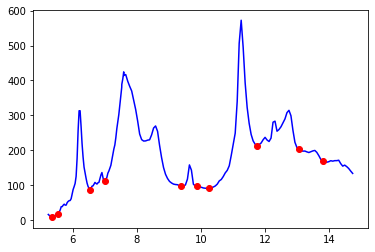

In [28]:
plt.plot(wave, flux, color='b')
plt.plot(xanchor, yanchor, 'ro')
#plt.plot(xanchor, spline, 'g+')
plt.show()


(27, 17, 194)


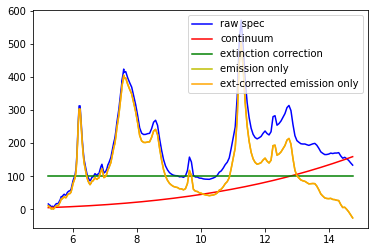

In [29]:
i = 18
j = 8

print(((spectra-cont)/ext).shape)
t=(spectra-cont)
tt=(spectra-cont)/ext
plt.plot(wave, spectra[i, j, :], color='b', label='raw spec')
plt.plot(wave, cont[i, j, :], color='r', label='continuum')
plt.plot(wave, ext[i,j,:]*100, color='g', label='extinction correction')
plt.plot(wave, t[i,j,:], color='y', label='emission only')
plt.plot(wave, tt[i,j,:], color='orange', label='ext-corrected emission only')
plt.legend()
plt.show()


In [30]:
#in the above plot it just happens that the emission only spectrum and the emission only spectrum which has been extinction corrected coincide.


In [31]:
df=np.zeros(shape=(10,5))
print(df)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [32]:
df[1]=[1,2,3,4,5]
print(df)

[[0. 0. 0. 0. 0.]
 [1. 2. 3. 4. 5.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [33]:
x=[1,3,7,9,8]
df[2]=x
print(df)

[[0. 0. 0. 0. 0.]
 [1. 2. 3. 4. 5.]
 [1. 3. 7. 9. 8.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [34]:
from pre_processing import *
import numpy as np

In [35]:
df=np.random.rand(27, 17, 194)

In [36]:
df=df_create(df)

In [37]:
print(df.shape)

print(df.mean(axis=0))

(459, 194)
[0.48684686 0.47562503 0.51734636 0.49653135 0.50197036 0.49697313
 0.48086713 0.46935111 0.49649036 0.50721597 0.48396794 0.49873471
 0.48186285 0.47126353 0.50362963 0.50698978 0.48687017 0.47948579
 0.49586489 0.48136625 0.52108987 0.48445154 0.51778593 0.50612261
 0.49844032 0.48653737 0.50139769 0.49082533 0.50582187 0.50293182
 0.48260661 0.51716574 0.48378041 0.50395164 0.50807298 0.5246066
 0.51263959 0.52286265 0.5002001  0.50093474 0.49271607 0.490309
 0.50034261 0.50467876 0.5134131  0.49883683 0.49104885 0.49266844
 0.48245091 0.47531833 0.52124192 0.4913143  0.48901047 0.48066996
 0.4918778  0.51820805 0.48020805 0.49650249 0.50356552 0.51664992
 0.50007086 0.45886779 0.50460798 0.49009506 0.49154532 0.50196428
 0.465066   0.49335184 0.49627928 0.50652878 0.48568967 0.51916879
 0.48693327 0.49554375 0.48711745 0.52089477 0.48501213 0.49089813
 0.4885634  0.48706502 0.50796976 0.4890058  0.51156105 0.48768782
 0.51649198 0.51415971 0.52919544 0.50259775 0.5037081

### SOFIA- trying to figure out what is happening with the "cluster maps" Christiaan has shared w me:

In [39]:
##load in the map and lets check out the size/shape
map_file= "NGC2023_ZONES_MAP_SOUTH.fits"
hdulist = fits.open(folder+map_file)

In [41]:
hdulist.info()

Filename: /Volumes/LaCie/MASTERS/NGC2023_IRS_Boersma_2016/NGC2023_ZONES_MAP_SOUTH.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (27, 17)   int32   


In [43]:
map=hdulist[0].data
map.shape

(17, 27)

In [47]:
print(map[0:16,:])

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 3 3]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 4]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 4 4]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 4 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 4 4 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3 4 4 4 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 3 3 3 3 3 4 4 4 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 4 4 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 4 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 3 3 4 4 4 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 3 3 3 3 4 3 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 4 3 4 4 4 4 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3 4 4 4 4 0]]


### SOFIA- now trying to figure out how to create the figure with the averaged spectra

In [1]:
#lets just try running algorithm 1 and then using those results to create the averaged spectra

#import relevant packages
# from processing import optimal_clusters_inspect, pca_visual, plot_dendrogram
from spec_build import *
from pre_processing import *
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

##SOFIA- currently working only with the South files, pondering how best to
#consolidate the South data files into the dataset

#load in and reshape all wavelength, extinction, spectral maps
spectra, wave= load_spec_wavelength("NGC2023_SPECTRAL_MAP_SOUTH.fits")

#load in and reshape continuum and corresponding wavelentgh arrays
cont, wave_cont=load_continuum("NGC2023_CONTINUUM_MAP_SOUTH.fits")

#load in and reshape the extinction maps and corresponding wavelength array
ext, wave_ext=load_extinction("NGC2023_EXTINCTION_MAPS_SOUTH.fits")

#extinction correct the spectra
##SOFIA-comment this line out when performing clustering on spectra that have
#NOT been extinction corrected
# ext_corr_spec=extinction_correct(ext, spectra)

#pre-processing

#transform the map(s) from 3 to 2-dimensional array(s and consolidate)
df=df_create(spectra)

#apply normalization to the spectra
df=normalize(df)
#uncomment the line below if you want to normalize wrt the 7.7 micro meter flux:
# df=normalize_77(df)

#processing- the algorithm itself

#start by determining the optimal number of clusters to use

clusters_range=[2,3,4,5,6,7,8] #can change to anything you like

#create an elbow plot to visualize the difference between the quality of clustering for each number of clusters
# elbow_plot(cluster_range=clusters_range, data=df)

#visually inspect the clusters to determine the optimal number of clusters
# optimal_clusters_inspect(clusters_range, df)

#prompt the user for the optimal number of clusters going forwards
# optimal_n_clusters=int(input("Please input the optimal number of clusters: "))

#deploy agglomerative clustering with optimal number of clusters
##SOFIA- consider re-coding this in a method in the clustering module?

#first perform PCA to retrieve parameter space dimensions
# pca = PCA(n_components = 2) # use 2 from Ameek's paper- could also experiment with others...
# df_pca = pca.fit_transform(df)

#apply the agglomerative clustering algorithm with optimal number of clusters
clusterer=AgglomerativeClustering(n_clusters=4, compute_distances=True) #SOFIA- experiment/finalize parameter settings
cluster_labels=clusterer.fit_predict(df)

# #now plot the results
# #plot in pc space, color-code by cluster
# for i in range(optimal_n_clusters):
#     color = cm.nipy_spectral(float(i) / optimal_n_clusters)
#     plt.scatter(df_pca[cluster_labels==i, 0], df_pca[cluster_labels==i, 1], 
#                 label='Cluster %i' % (i+1))

# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.title('PCA-transformed plot for %i clusters' % optimal_n_clusters)
# plt.legend()
# plt.show()


# #now lets try for a dendrogram visual
# plt.title("Hierarchical Clustering Dendrogram")
# # plot the top three levels of the dendrogram
# plot_dendrogram(clusterer, truncate_mode="none")
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

#analyze key features of spectra groups/clusters here



In [2]:
#now lets see what shape are the labels/spectra
print(cluster_labels.shape)
print(spectra.shape)

(459,)
(27, 17, 194)


In [3]:
#have to define a new function that somehow takes the 2-D array and re-constructs the 3D cube from it!
#in this case (the Spitzer south maps) the dimensions will be 27 x 17x 1 where the third dimension is the cluster labels

rows=27
cols=17

#SOFIA- maybe I can use np.reshape here?!- YESSS!
# a=np.arange(6)
# b=np.c_[a,a,a]
# print(b.shape)
# print(b)

# c=np.reshape(b, (18,1), order="C")
# print(c)

# #now back to the original shape
# d=np.reshape(c, (6,3), order="C")
# print(d)


label_matrix=np.reshape(cluster_labels, (rows, cols))
print(label_matrix.shape)
print(label_matrix[0,:])
        

(27, 17)
[1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


### SOFIA- trying to figure out how to code the averaged spectra per cluster zone
#### Idea: write a function that just calculates the averaged spectra for a given label

In [4]:

def avg_label(label, spectra, labels): #inputs are an integer label, the array holding the spectra, and the array holding the labels
    
    specs_list=[] #an empty list- will hold all the spectra (arrays) for the specified label
    
    #iterate through the labels array
    #the first two indices in the spectra array match those in the labels array
    for i in range(labels.shape[0]): #across the rows
        for j in range(labels.shape[1]): #across the columns
            
            #save all the corresponding spectra
            if labels[i,j]==label:
                specs_list.append(spectra[i,j,:]) #save the spectrum to the list
     
    specs_array=np.array(specs_list) #create an array of the spectra (easier for the following operations)
    
    #average them up- we want to average along each flux value
    #we construct the averaged spectrum one wavelength at a time
    avg_spec=np.zeros((specs_array.shape[1])) #an empty array to hold each of the flux values
    
    for wavelength in range(specs_array.shape[1]): # iterate across the wavelength dimension
        #calculate the average flux value for each wavelength
        avg_flux_value=np.mean(specs_array[:,wavelength]) 
        #now save the flux value in the corresponding position in the container for the averaged spectrum
        avg_spec[wavelength]=avg_flux_value
        
    #now return the averaged spectrum for the given label
    return avg_spec







#plot the averaged spectrum for the label

In [13]:
avg_spec=avg_label(1, spectra, label_matrix)

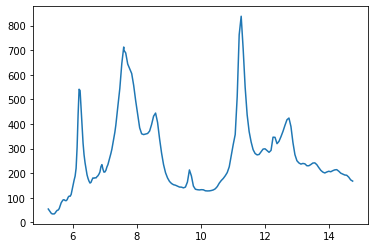

In [14]:
plt.plot(wave, avg_spec )
plt.show()

## SOFIA- have to add this code to the repo, also check that the averaging works properly, those flux values look kinda big?

AttributeError: 'Line2D' object has no property 'lable'

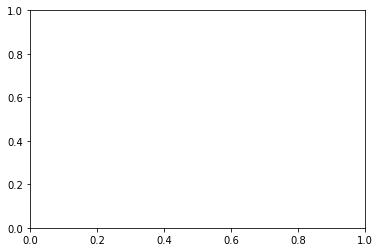

In [9]:
for i in range(4):
    avg_spec=avg_label(i, spectra, label_matrix)
    plt.plot(wave, avg_spec, lable=f"label: {i}")
    plt.legend(loc=best)
    plt.show()